**A1.4A.11**: Does the system support transfer learning (i.e model trained on one task being re-purposed for a second related task)?

# Fine-tuning VGG16 backbone

We fine-tune the last four layers of VGG16, despite the image highlighting only the last two layers as trainable. I has around 138 millions parameters.

In [4]:
from IPython.display import display, HTML

def show_svg(url):
    svg_html = f'''
    <img src="{url}" 
    width="1000" height="300"/>
    '''
    display(HTML(svg_html))

show_svg("https://storage.googleapis.com/lds-media/images/transfer-learning-fine-tuning-approach.width-1200.jpg")

## Model Training

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

# Step 1: Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Repeat the grayscale channel 3 times
x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

# Resize the images to meet the model's expected input shape
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Step 2: Load the VGG16 model without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3)) # change input_shape to (28, 28, 3)


# Step 3: Add a custom top layer to the VGG16 model
flatten = Flatten()(base_model.output)
output = Dense(10, activation='softmax')(flatten)

model = Model(inputs=base_model.input, outputs=output)

# Step 4: Freeze some layers and fine-tune the rest
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Step 5: Compile and train the model with fine-tuning
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=1, validation_data=(x_test, y_test))

# Step 6: Save the model
model.save('/project_data/data_asset/5c_mnist_vgg16_fine_tuned.h5')

# Step 7: Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


313/313 [==============================] - 3s 9ms/step - loss: 0.0436 - accuracy: 0.9871
Test Loss: 0.04363180696964264
Test Accuracy: 0.9871000051498413


## Model Prediction

In [5]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

# Step 1: Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Repeat the grayscale channel 3 times
x_train = np.stack([x_train]*3, axis=-1)
x_test = np.stack([x_test]*3, axis=-1)

# Resize the images to meet the model's expected input shape
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


# Load the saved model
loaded_model = tf.keras.models.load_model('/project_data/data_asset/5c_mnist_vgg16_fine_tuned.h5')

# Predict first 10 images
predictions_10 = loaded_model.predict(x_test[:10])
predicted_labels_10 = tf.argmax(predictions_10, axis=1).numpy()
actual_labels_10 = tf.argmax(y_test[:10], axis=1).numpy()

print('Predicted labels for first 10 images:', predicted_labels_10)
print('Actual labels for first 10 images:', actual_labels_10)


1/1 [==============================] - 0s 226ms/step
Predicted labels for first 10 images: [7 2 1 0 4 1 4 9 5 9]
Actual labels for first 10 images: [7 2 1 0 4 1 4 9 5 9]


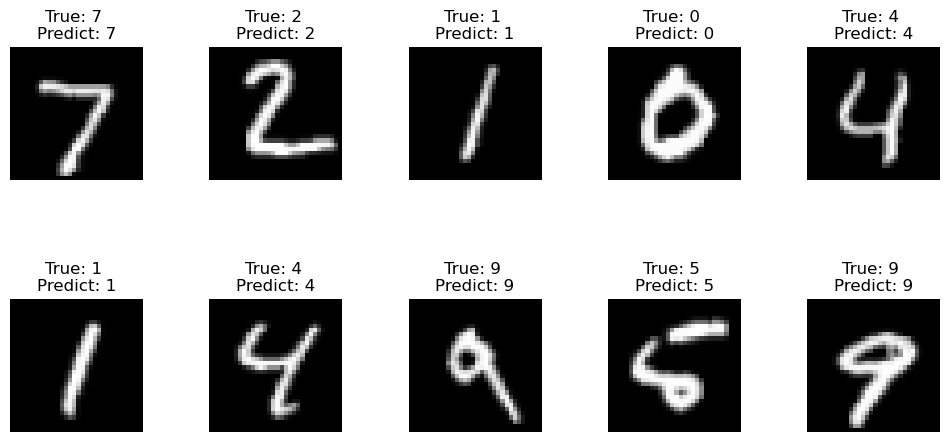

In [2]:
import matplotlib.pyplot as plt

# Display first 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in np.arange(0, 10):
    axes[i].imshow(x_test[i], cmap='gray')
    axes[i].set_title("True: %s \nPredict: %s" % (actual_labels_10[i], predicted_labels_10[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()